# เริ่มต้น CUDA Programming

วันนี้เราจะทำความเข้าใจเกี่ยวกับ CUDA ซึ่งเป็นแพลตฟอร์มและโมเดลการเขียนโปรแกรมที่ออกแบบมาเพื่อให้สามารถใช้งาน Graphics Processing Unit (GPU) สำหรับการคำนวณแบบขนาดใหญ่ได้อย่างมีประสิทธิภาพ เราจะดำเนินการดาวน์โหลดภาพ ปรับขนาดภาพ แปลงภาพจาก RGB ไปเป็นภาพเฉดสีเทา และทำการคูณเมทริกซ์โดยใช้ CUDA ในการทำงานดังกล่าว

import library ที่จำเป็น เช่น matplotlib, pytorch สังเกต torch.utils.cpp_extension import load_inline ที่จะใช้ในการโหลด code ภาษา cpp

In [1]:
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io

from torch.utils.cpp_extension import load_inline

ดาวน์โหลรูปภาพจากอินเตอร์เน็ต

In [2]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Daikichi_pug.jpg/1024px-Daikichi_pug.jpg'

In [3]:
path_img = Path('puppy.jpg')
if not path_img.exists(): urlretrieve(url, path_img)

ดูขนาดรูป ดูตัวอย่างข้อมูล RGB เป็น tensor 3 มิติ (channels, height, width)

In [4]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 683, 1024])


tensor([[[129, 126, 126, 129],
         [130, 127, 128, 131],
         [130, 129, 129, 131]],

        [[113, 110, 108, 111],
         [114, 111, 110, 113],
         [114, 113, 113, 115]]], dtype=torch.uint8)

ดูรูป

มีการสลับ channel เนื่องจาก pytorch กับ matplotlib เรียงมิติไม่เหมือนกัน CHW -> HWC

In [5]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

resize ย่อรูป ให้กว้าง 150 ก็พอ จะได้รันไม่นาน ยิ่งใช้ Python ปกติ ถ้าใช้รูปใหญ่จะช้ามาก

In [6]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 224, 33600)

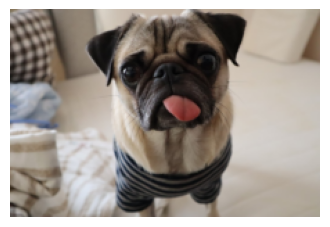

In [7]:
show_img(img2)

## แปลงรูปสี RGB -> เป็นรูปขาวดำ Greyscale

### Basic Python

วน loop แปลงทีละ pixel ทีเดียว 3 channel ด้วยสูตร 0.2989*r + 0.5870*g + 0.1140*b

In [8]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

ลองจับเวลา  ใช้เวลา เกือบ 2 วินาที สำหรับรูปเล็ก

ถ้ามีเวลา ลองใช้รูปใหญ่ดู ว่าใช้เวลาเท่าไร

In [11]:
%%time
img_g = rgb2grey_py(img2)
# img_g = rgb2grey_py(img)

CPU times: user 1.33 s, sys: 4.1 ms, total: 1.34 s
Wall time: 1.35 s


แสดงผลลัพธ์ ภาพขาวดำ greyscale ที่ได้

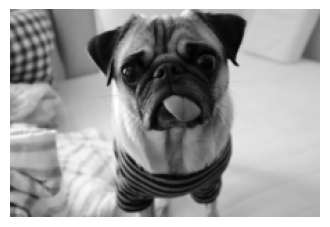

In [12]:
show_img(img_g, cmap='gray')

### Python Kernel
ลองสร้าง kernel ด้วยภาษา Python

สร้าง function เป็น kernel

In [13]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

สร้าง function สำหรับวน loop จำลอง การรัน kernal (จริง ๆ เดี๋ยวใน CUDA จะเป็นการ run แบบ parallel)

In [14]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

หมายเหตุ: kernel ไม่สามารถ return ค่าได้ มันได้แต่เปลี่ยนแปลง content ของ parameter ที่รับเข้าไปเท่านั้น

มาถึง Main program จัดเตรียม Input, Output ส่งให้ตัวรัน kernel พร้อม ชื่อ kernal

In [15]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

ลองรัน จับเวลา ได้ความเร็วเท่าเดิม

In [16]:
%%time
img_g = rgb2grey_pyk(img2)

CPU times: user 1.39 s, sys: 39 ms, total: 1.43 s
Wall time: 1.39 s


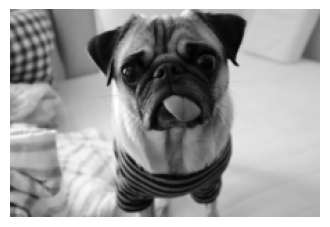

In [17]:
show_img(img_g, cmap='gray')
# show_img(img_g)

### Python Block Kernel

GPU และ CUDA ไม่ได้ทำงานแต่ละ thread แยกกันหมด แต่จะมีส่วนร่วมกัน โดยผูกกับ Hardware เรียกว่า Block หรือ Streaming Multiprocessor (SM) ที่จะมี Shared Memery ร่วมกัน

เราจะจำลอง ไอเดียนี้ขึ้นมาใน code python ด้วยการสร้าง ตัวรัน kernel ใหม่ ที่ วน nested loop เรียกใช้งาน kernel ทีละ block ทีละ thread ซ้อนกัน

In [18]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

เราจะอัพเดท kernel โดยเอา block index, thread index และ block dimension (ความกว้างของ block) มาใช้ในการคำนวน หาว่า ทำงานถึงไหนแล้ว จะได้ไปหยิบข้อมูลใน memory มาทำต่อได้ถูกที่

In [19]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

Main โปรแกรมคล้าย ๆ เดิม แต่มีการคำนวน ว่าจะวิ่งกี่ block เนื่องจาก ขนาดภาพอาจ หารด้วย ขนาด block ไม่ลงตัว ทำให้ block สุดท้าย ต้องวิ่งเกินไป แล้ว เช็คใน kernel ว่า if i<n ถึงจะทำงาน ถ้าเกินก็ไม่ต้องทำงาน

In [20]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

เวลาเท่าเดิม เพราะยังไม่ได้ใช้ GPU

In [21]:
%%time
img_g = rgb2grey_pybk(img2)

CPU times: user 1.91 s, sys: 16.4 ms, total: 1.92 s
Wall time: 1.99 s


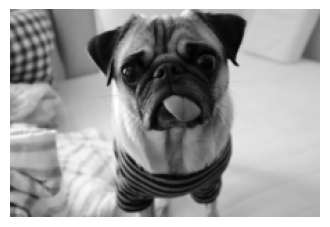

In [22]:
show_img(img_g, cmap='gray')

### CUDA Setup

เราจะมาเริ่มใช้ CUDA กัน

install library ที่จำเป็น ในที่นี้คือ wurlitzer ที่ใช้ในการ print log และ ninja เป็น build tools ที่เราจะใช้ในการ compile cpp แล้วเรียกใช้จากใน python ได้


In [23]:
%pip install -q wurlitzer ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.0 MB/s eta 0:00:00


สำหรับ debug ถ้ามีปัญหา ใน code CUDA ให้หยุด

In [24]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

โหลด wurlitzer จะได้ print log จาก gpu ได้ ไม่งั้นจะไม่แสดงใน console

In [25]:
%load_ext wurlitzer

boilerplate ในการโหลด cpp code ด้วย load_inline ของ pytorch torch.utils.cpp_extension

In [26]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

macro, header ต่าง ๆ สำหรับ เช็คข้อมูล input, output, เช็ค GPU ทำงานอยู่ไหม

In [27]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

### CUDA kernel

code python block kernel ด้านบน เราเอาไปให้ chatgpt แปลงเป็น cpp

- 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
- 1024 max threads per block (use a multiple of 32)

In [28]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

interface สำหรับ python

In [29]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

เริ่ม build

In [30]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/

Loading extension module inline_ext...


build ได้ อะไรออกมาเต็มไปหมด


In [31]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grayscale']

มี function rgb_to_grayscale

In [32]:
dir(module.rgb_to_grayscale)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']

เตรียม parameter เราจะ make sure ว่า รูปอยู่ใน memory ต่อเนื่องกัน และ โหลดขึ้น GPU

In [33]:
imgc = img.contiguous().cuda()

In [34]:
imgc.shape

torch.Size([3, 683, 1024])

ลองจับเวลา เหลือเพียง ประมาณ 2ms สำหรับรูปใหญ่ ขนาดเต็ม ๆ ไม่ได้ resize ย่อ ให้เล็กลง

In [35]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 443 µs, sys: 1.02 ms, total: 1.47 ms
Wall time: 2.23 ms


(683, 1024, 699392)

h*w: 683*1024


แสดงผลรูปขาวดำ greyscale ที่ได้

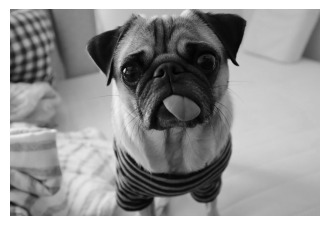

In [36]:
show_img(res, cmap='gray')

## Matmul

### Get data

In [37]:
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [38]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [39]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [40]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

tensor(5)


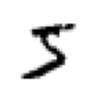

In [41]:
print(y_train[0])
show_img(imgs[0], cmap='gray_r', figsize=(1,1))

tensor(0)


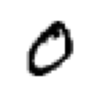

In [42]:
print(y_train[1])
show_img(imgs[1], cmap='gray_r', figsize=(1,1))

tensor(4)


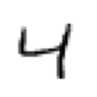

In [43]:
print(y_train[2])
show_img(imgs[2], cmap='gray_r', figsize=(1,1))

tensor(1)


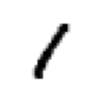

In [44]:
print(y_train[3])
show_img(imgs[3], cmap='gray_r', figsize=(1,1))

In [45]:
28*28

784

In [46]:
torch.manual_seed(1)
weights = torch.randn(784,10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

### Python matmul

In [47]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [48]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [49]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [50]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [51]:
t1.shape

torch.Size([5, 10])

In [52]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [53]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [54]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [55]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [56]:
%time _=matmul(m1, m2)

CPU times: user 742 ms, sys: 1.22 ms, total: 743 ms
Wall time: 759 ms


In [57]:
ar*bc*ac

39200

### 2d Python kernel

In [58]:
from types import SimpleNamespace as ns

In [59]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(ns(x=i0,y=i1), ns(x=j0,y=j1), threads, *args)

In [60]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x

    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

In [61]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [62]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

tensor(True)

### Broadcasting

In [63]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [64]:
m1.shape

torch.Size([5, 784])

In [65]:
m1[0].shape

torch.Size([784])

In [66]:
m1[0,:].shape

torch.Size([784])

In [67]:
m1[0,:,None].shape

torch.Size([784, 1])

In [68]:
m1[0, None].shape

torch.Size([1, 784])

In [69]:
m1[None, 0].shape

torch.Size([1, 784])

In [70]:
# m1[None, 0]

In [71]:
torch.isclose(t1,matmul(m1, m2)).all()

tensor(True)

In [72]:
%time _=matmul(m1, m2)

CPU times: user 354 µs, sys: 0 ns, total: 354 µs
Wall time: 362 µs


In [73]:
m1 = x_train
tr = matmul(m1, m2)
tr.shape

torch.Size([50000, 10])

In [74]:
%time _=matmul(m1, m2)

CPU times: user 1.31 s, sys: 11.8 ms, total: 1.32 s
Wall time: 1.34 s


In [75]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000

### RGB->Grey CUDA 3d

In [76]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int w, int h) {
    int c = blockIdx.x*blockDim.x + threadIdx.x;
    int r = blockIdx.y*blockDim.y + threadIdx.y;

    if (c<w && r<h) {
        int i = r*w + c;
        int n = h*w;
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w, h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [77]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

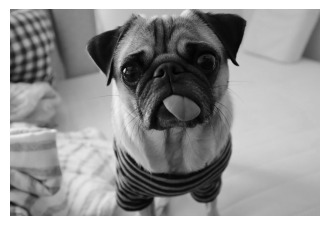

In [78]:
res = module.rgb_to_grayscale(imgc).cpu()
show_img(res, cmap='gray')

### CUDA matmul

In [79]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [80]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [81]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

In [82]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [83]:
torch.isclose(tr, module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

tensor(True)

In [84]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

CPU times: user 4.99 ms, sys: 78 µs, total: 5.07 ms
Wall time: 5.49 ms


torch.Size([50000, 10])

### Pytorch

In [85]:
torch.isclose(tr, (m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

In [86]:
%timeit -n 10 _=(m1c@m2c).cpu()

2.07 ms ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


##Credit
- https://github.com/cuda-mode/lectures/blob/main/lecture3/pmpp.ipynb
- https://developer.nvidia.com/cuda-education-training